In [43]:
#to import the necessary libraries

import numpy as np  
import matplotlib.pyplot as plt  #to plot the graphs
import scipy.io as sc  
from tensorflow.keras.utils import to_categorical
from tensorflow import keras
import seaborn as sns


In [44]:
#Step 1 - Loading the data input using sc
#Input is 32X32 training and testing SVHN datasets
#Training samples - 73257, testing samples - 26032
'''trX - training data,
   trY - training label,
   tsX - testing data,
   tsY - testing label'''

trX = sc.loadmat('train_32x32.mat')['X']
trY = sc.loadmat('train_32x32.mat')['y']
tsX = sc.loadmat('test_32x32.mat')['X']
tsY = sc.loadmat('test_32x32.mat')['y']

#Saving a copy of input data loaded
train_data = trX
train_label = trY
test_data = tsX
test_label = tsY

#displaying the minimum and maximum value of training data
np.min(train_data)
np.max(train_data)


255

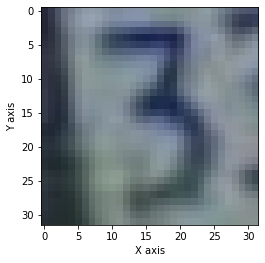

Label of above data: [3]


In [45]:
#displaying a random data of training sample and it's corresponding label - to view an example of how input data is
'''Digit 1 - label 1
   Digit 9 - label 9
   Digit 0 - label 10'''

plt.xlabel("X axis")
plt.ylabel("Y axis")
plt.imshow(train_data[20000])
plt.show()
print('Label of above data:', train_label[20000])

In [46]:
#Step 2a: Normalizing the training and testing data to the range 0-1
'''Normalizing is done to speed up the convergence.
   it makes the cost function much easier to train
   minimum value is normalized to 0
   maximum value is normalized to 1
   norm_train - normalized value of training data
   norm_test - normalized value of testing data'''

norm_train = (train_data - np.min(train_data)) / (np.max(train_data) - np.min(train_data))
norm_test = (test_data - np.min(test_data)) / (np.max(test_data) - np.min(test_data))
#norm_train
np.min(norm_test)



0.0

In [47]:
#Step 2b: One hot vector encoding - mapping of categorical values to integers
'''Then, each integer value is represented as a binary vector that is all zero values except 
   the index of the integer, which is marked with a 1
   using the inbuilt function to_categorical from keras, to do the one hot vector encoding of training and testing labels
   onehot_train - hot coded data of training set
   onehot_test - hot coded data of testing set'''

onehot_train = to_categorical(train_label)
onehot_test = to_categorical(test_label)
print ("One hot vector encoding results of training data")
print (onehot_train)

One hot vector encoding results of training data
[[0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]]


In [49]:
#Step 3: Implementing the architecture mentioned in the problem statement
'''Problem Statement: 1. 2d convolution with 5X5 kernel, 64 output maps and ReLU activation function
   2. Maxpooling with kernel 2X2 and stride 2X2
   3. 2d convolution with 5X5 kernel, 64 output maps and ReLU activation function
   4. Maxpooling with kernel 2X2 and stride 2X2
   5. 2d convolution with 5X5 kernel, 128 output maps and ReLU activation function
   6. regular network with 3072 units and ReLU activation unit
   7. regular network with 2048 units and ReLU activation unit
   8. final network with 10 units and softmax activation unit
   strides: the number of pixels by which a kernel is moved
   kernel: filter used to extract features from the image
   Convolution: The input is multiplied element-by-element with the filter throughout the process
   For all the convolutional layers, using padding='same' 
   Drop-out: added after each maxpooling to prevent the neurons from learning the same
   Maxpooling: calculates the maximum value in each patch, extracts the sharpest features of an image
   BatchNormalization: it is done to eliminate internal covariate shift issue
   Flatten: 
   ReLU activation function - linear function that will give output=input, if its positive else output=0
   Softmax activation function - maps a vector of numbers into a vector of probabilities  '''
  


#Keras manages a global state, therefore need to clear all the session before starting
keras.backend.clear_session()

#Defining keras sequential model - the sequential API allows to create models layer-by-layer
seq_model = keras.Sequential([
    keras.layers.Conv2D(64, (5, 5), padding='same', 
                           activation='relu',
                           input_shape=(32, 32, 3)),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D((2, 2), (2,2)),
    
    keras.layers.Conv2D(64, (5, 5), padding='same', 
                           activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D((2, 2), (2,2)),
    
    keras.layers.Conv2D(128, (5, 5), padding='same', 
                           activation='relu'),
    keras.layers.Flatten(),
    keras.layers.Dense(3072, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(2048, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(10, activation='softmax'),
])



#Step 4: Model training using SGD optimizer
#using the SGD(stochastic gradient descent) optimizer as per problem statement
'''SGD calculates the gradient of the cost function of a single example at each iteration
   learning rate - rate at which the model learns. Small learning rate - more optimal solution
   Optimization -process which optimize the input weights by comparing the prediction and the loss function
   Metrics - used to evaluate the performance the model
   Loss function - used to find error or deviation in the learning process'''

sgd_optimizer = keras.optimizers.SGD(learning_rate=0.01)
seq_model.compile(optimizer=sgd_optimizer,
                  loss='categorical_crossentropy',
                  metrics='accuracy')
    
#to view complete architecture of the model
seq_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 64)        4864      
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 64)       256       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 64)        102464    
                                                                 
 batch_normalization_1 (Batc  (None, 16, 16, 64)       256       
 hNormalization)                                                 
                                                        

In [50]:
#training the model with normalized training samples and hot coded training labels
#20% of the trained samples are taken for validation
#epochs define the number of samples

trained_data = seq_model.fit(norm_train, onehot_train, batch_size=128, epochs=20, validation_split=0.2)

Epoch 1/20
458/458 [==============================] - 12s 25ms/step - loss: 1.0652 - accuracy: 0.6557 - val_loss: 0.7450 - val_accuracy: 0.8112
Epoch 2/20
458/458 [==============================] - 10s 23ms/step - loss: 0.4995 - accuracy: 0.8511 - val_loss: 0.5014 - val_accuracy: 0.8514
Epoch 3/20
458/458 [==============================] - 10s 21ms/step - loss: 0.4051 - accuracy: 0.8808 - val_loss: 0.4156 - val_accuracy: 0.8797
Epoch 4/20
458/458 [==============================] - 10s 22ms/step - loss: 0.3491 - accuracy: 0.8975 - val_loss: 0.4050 - val_accuracy: 0.8810
Epoch 5/20
458/458 [==============================] - 10s 23ms/step - loss: 0.3090 - accuracy: 0.9088 - val_loss: 0.3805 - val_accuracy: 0.8896
Epoch 6/20
458/458 [==============================] - 10s 22ms/step - loss: 0.2782 - accuracy: 0.9183 - val_loss: 0.3308 - val_accuracy: 0.9034
Epoch 7/20
458/458 [==============================] - 10s 22ms/step - loss: 0.2493 - accuracy: 0.9281 - val_loss: 0.3215 - val_accuracy:

In [51]:
#calculating the training and validation accuracy of trained data
train_acc = trained_data.history['accuracy']
val_acc = trained_data.history['val_accuracy']

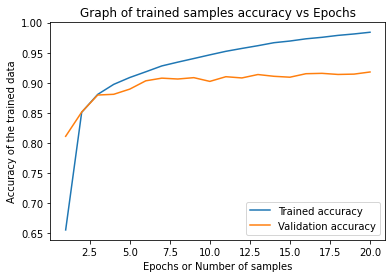

In [53]:
#Step 5: plotting the training curve as the function of accuracy of trained samples with the epochs
sns.lineplot(x = range(1,21), y = train_acc, label = 'Trained accuracy')
sns.lineplot(x = range(1,21), y = val_acc, label = 'Validation accuracy')
plt.xlabel('Epochs or Number of samples')

plt.ylabel('Accuracy of the trained data')
plt.legend(loc='lower right')
plt.title('Graph of trained samples accuracy vs Epochs')
plt.show()

In [54]:
#Testing the model accuracy on testing samples - evaluation of the model for test samples
'''Evaluation of test data: checks whether the model is best fit for the given problem and its corresponding data'''
test_loss, test_accuracy = seq_model.evaluate(x=norm_test, y=onehot_test, verbose=0)


#Final accuracy in classification of the testing set is calculated
print('Test accuracy is: {:0.4f} \nTest loss is: {:0.4f}'.
      format(test_accuracy, test_loss))

Test accuracy is: 0.9062 
Test loss is: 0.3757
